## 1. importing packages

In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import datetime as dt
import pandas_datareader as web
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import matplotlib.ticker as ticker
import itertools

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow.keras import optimizers

import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


## 2. overall configurations

In [349]:
%matplotlib inline


tqdm.pandas()
sns.set(style='whitegrid',palette='muted')
rcParams['figure.figsize'] = 14, 10

## 3. Getting the Data

In [350]:
import yfinance as yf
ticket = yf.Ticker('BOVA11.SA')
start = dt.datetime(2009, 1, 2) # First register data
end = dt.datetime(dt.datetime.now().year,dt.datetime.now().month,dt.datetime.now().day - 2)

bova11 = ticket.history(interval= '1d', start = start, end = end).reset_index()
bova11
bova11_copy = bova11.copy()

In [351]:
len(bova11)

3493

## 4. Pre-processing

Adjust the columns name and type

In [352]:
bova11.columns = bova11.columns.str.lower()

In [353]:
bova11.date = pd.to_datetime(bova11.date)

In [354]:
bova11.isna().sum()

date            0
open            0
high            0
low             0
close           0
volume          0
dividends       0
stock splits    0
dtype: int64

Removing rows with volume 0

In [355]:
bova11 = bova11.loc[(bova11.volume != 0)].reset_index()
bova11.drop(columns='index', axis = 1, inplace = True)
bova11

,date,open,high,low,close,volume,dividends,stock splits
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0
...,...,...,...,...,...,...,...,...
3395,2023-01-23 00:00:00-03:00,108.889999,109.330002,107.879997,107.900002,4401425,0,0
3396,2023-01-24 00:00:00-03:00,108.709999,109.430000,107.970001,109.430000,5724141,0,0
3397,2023-01-25 00:00:00-03:00,109.000000,110.680000,108.209999,110.650002,6427546,0,0
3398,2023-01-26 00:00:00-03:00,110.699997,111.099998,109.860001,110.419998,4382206,0,0


Sorting the data by date

In [356]:
bova11 = bova11.sort_values(by='date').reset_index(drop=True)

Adding a column with the previous close value

In [357]:
bova11["prev_close"] = bova11.shift(1)["close"]

In [358]:
bova11.head()

,date,open,high,low,close,volume,dividends,stock splits,prev_close
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0,NaN
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0,40.320000
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0,42.000000
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0,42.320000
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0,40.639999


Adding the close difference between dates

In [359]:
bova11["close_change"]= bova11.progress_apply(
    lambda row: 0 if np.isnan(row.prev_close) else row.close - row.prev_close,
    axis = 1
)

100%|██████████| 3400/3400 [00:00<00:00, 11936.29it/s]


In [360]:
bova11.head()

,date,open,high,low,close,volume,dividends,stock splits,prev_close,close_change
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0,NaN,0.000000
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0,40.320000,1.680000
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0,42.000000,0.320000
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0,42.320000,-1.680000
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0,40.639999,1.560001


Checking the dataseries over time

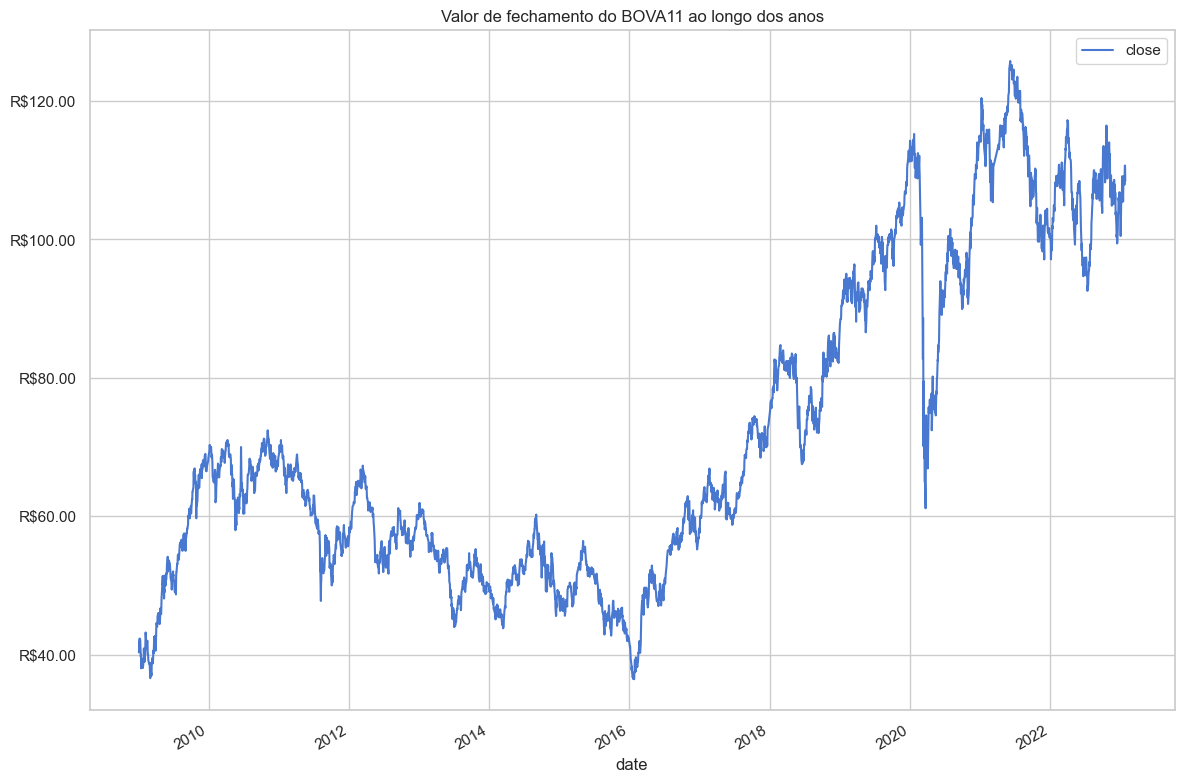

In [361]:
daily_closing = bova11[['date','close']]
daily_closing = daily_closing.set_index('date')
ax = daily_closing.plot()
plt.title('Valor de fechamento do BOVA11 ao longo dos anos')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("R${x:,.2f}"))

#### Feature Engineering
Add auxiliar columns that can improve our model, like moving averages,standard deviation, techinical indicators and others
Let's add:
- Moving_average for 3, 10, 30 and 60 days
- Standard deviation for 7, 30 and 60 days
- Bollinger limits for Upper and lowers 3, 30 and 60
- Add RSI indicator

In [362]:
# Adding move Averages columns
bova11['ma_3d'] = bova11['close'].rolling(3, center = True, min_periods=1).mean()
bova11['ma_10d'] = bova11['close'].rolling(10, center = True,min_periods=1).mean()
bova11['ma_30d'] = bova11['close'].rolling(30, center=True, min_periods=1).mean()
bova11['ma_60d'] = bova11['close'].rolling(60, center = True, min_periods = 1).mean()

In [363]:
# Adding standard deviation columns
bova11['std_7'] = bova11['close'].rolling(7, center = True, min_periods = 1).std()
bova11['std_30'] = bova11['close'].rolling(30, center = True, min_periods = 1).std()
bova11['std_60'] = bova11['close'].rolling(60, center = True, min_periods = 1).std()

In [364]:
# Adding the bollinger bands
bova11['upper3'] = bova11['ma_3d'] + 2*bova11['close'].rolling(3, center = True, min_periods = 1).std()
bova11['lower3'] = bova11['ma_3d'] - 2*bova11['close'].rolling(3, center = True, min_periods = 1).std()

bova11['upper30'] = bova11['ma_30d'] + 2*bova11['std_30']
bova11['lower30'] = bova11['ma_30d'] - 2*bova11['std_30']

bova11['upper60'] = bova11['ma_60d'] + 2*bova11['std_60']
bova11['lower60'] = bova11['ma_60d'] - 2*bova11['std_60']

# Adding tecnical indicator RSI
bova11['RSI'] = ta.rsi(bova11['close'], length = 15)

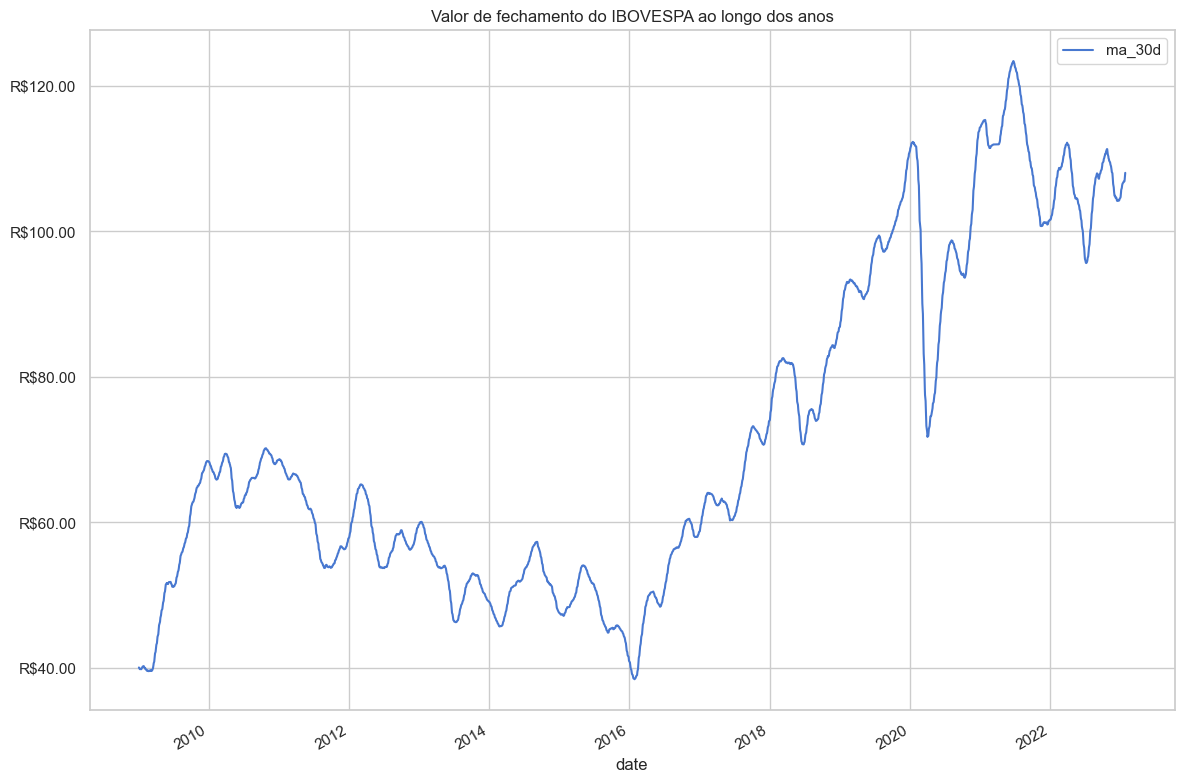

In [365]:
moving_avg = bova11[['date','ma_30d']]
moving_avg = moving_avg.set_index('date')
ax = moving_avg.plot()
plt.title('Valor de fechamento do IBOVESPA ao longo dos anos')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("R${x:,.2f}"))

Select the features and the predict columns

In [366]:
bova11.drop(['date', 'volume', 'dividends', 'stock splits', 'prev_close'],
            axis = 1,
           inplace = True)


In [367]:
bova11

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,std_30,std_60,upper3,lower3,upper30,lower30,upper60,lower60,RSI
0,38.279999,40.320000,37.939999,40.320000,0.000000,41.160000,41.496000,40.072667,40.216334,0.987387,1.459904,1.394817,43.535879,38.784121,42.992476,37.152858,43.005967,37.426700,NaN
1,40.200001,42.000000,39.700001,42.000000,1.680000,41.546666,41.580000,39.948125,40.269033,0.941319,1.495795,1.402411,43.695279,39.398054,42.939715,36.956536,43.073854,37.464211,NaN
2,42.060001,42.320000,41.549999,42.320000,0.320000,41.653333,41.311429,39.892353,40.322813,0.866718,1.466439,1.412751,43.437411,39.869255,42.825231,36.959475,43.148315,37.497311,NaN
3,41.750000,41.770000,40.450001,40.639999,-1.680000,41.720000,41.147500,39.842223,40.313031,1.063445,1.438465,1.391637,43.594461,39.845539,42.719153,36.965292,43.096304,37.529757,NaN
4,40.150002,42.200001,40.150002,42.200001,1.560001,41.613333,40.801111,39.897895,40.303530,1.118613,1.418844,1.371508,43.311019,39.915647,42.735582,37.060208,43.046547,37.560513,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,108.889999,109.330002,107.879997,107.900002,-0.549995,108.593333,108.596001,106.900000,105.317715,1.053531,2.817145,3.189933,110.143343,107.043323,112.534290,101.265710,111.697582,98.937848,54.687174
3396,108.709999,109.430000,107.970001,109.430000,1.529999,109.326668,108.943334,107.124737,105.359412,1.044363,2.703879,3.228209,112.082486,106.570850,112.532494,101.716980,111.815830,98.902995,58.279485
3397,109.000000,110.680000,108.209999,110.650002,1.220001,110.166667,109.086250,107.493889,105.467273,1.143318,2.235961,3.215444,111.463175,108.870158,111.965811,103.021967,111.898162,99.036385,60.925992
3398,110.699997,111.099998,109.860001,110.419998,-0.230003,109.823334,109.194286,107.821765,105.628750,1.208904,1.804440,3.127998,112.299324,107.347344,111.430645,104.212884,111.884747,99.372754,60.155206


In [368]:
bova11['target'] = bova11.close - bova11.open
#bova11['targetClass'] = [1 if bova11.target[i] > 0 else 0 for i in range(len(bova11))]
bova11['targetNextClose'] = bova11['close'].shift(-1)

In [369]:
bova11

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,...,std_60,upper3,lower3,upper30,lower30,upper60,lower60,RSI,target,targetNextClose
0,38.279999,40.320000,37.939999,40.320000,0.000000,41.160000,41.496000,40.072667,40.216334,0.987387,...,1.394817,43.535879,38.784121,42.992476,37.152858,43.005967,37.426700,NaN,2.040001,42.000000
1,40.200001,42.000000,39.700001,42.000000,1.680000,41.546666,41.580000,39.948125,40.269033,0.941319,...,1.402411,43.695279,39.398054,42.939715,36.956536,43.073854,37.464211,NaN,1.799999,42.320000
2,42.060001,42.320000,41.549999,42.320000,0.320000,41.653333,41.311429,39.892353,40.322813,0.866718,...,1.412751,43.437411,39.869255,42.825231,36.959475,43.148315,37.497311,NaN,0.259998,40.639999
3,41.750000,41.770000,40.450001,40.639999,-1.680000,41.720000,41.147500,39.842223,40.313031,1.063445,...,1.391637,43.594461,39.845539,42.719153,36.965292,43.096304,37.529757,NaN,-1.110001,42.200001
4,40.150002,42.200001,40.150002,42.200001,1.560001,41.613333,40.801111,39.897895,40.303530,1.118613,...,1.371508,43.311019,39.915647,42.735582,37.060208,43.046547,37.560513,NaN,2.049999,42.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,108.889999,109.330002,107.879997,107.900002,-0.549995,108.593333,108.596001,106.900000,105.317715,1.053531,...,3.189933,110.143343,107.043323,112.534290,101.265710,111.697582,98.937848,54.687174,-0.989998,109.430000
3396,108.709999,109.430000,107.970001,109.430000,1.529999,109.326668,108.943334,107.124737,105.359412,1.044363,...,3.228209,112.082486,106.570850,112.532494,101.716980,111.815830,98.902995,58.279485,0.720001,110.650002
3397,109.000000,110.680000,108.209999,110.650002,1.220001,110.166667,109.086250,107.493889,105.467273,1.143318,...,3.215444,111.463175,108.870158,111.965811,103.021967,111.898162,99.036385,60.925992,1.650002,110.419998
3398,110.699997,111.099998,109.860001,110.419998,-0.230003,109.823334,109.194286,107.821765,105.628750,1.208904,...,3.127998,112.299324,107.347344,111.430645,104.212884,111.884747,99.372754,60.155206,-0.279999,108.400002


In [370]:
bova11.dropna(inplace = True)

In [371]:
scaler = MinMaxScaler(feature_range = (-1, 1))
bova11_scaled = scaler.fit_transform(bova11)
print(bova11_scaled)

[[-0.41052802 -0.95937954 -0.97594966 ... -0.34158244 -0.812735
  -0.94288915]
 [-0.39380423 -0.93549828 -0.95100022 ... -0.1145866  -0.81635782
  -0.94311308]
 [-0.38663696 -0.9468809  -0.94178467 ... -0.11645738 -0.82917641
  -0.90033593]
 ...
 [ 0.73146451  0.62526502  0.62373572 ...  0.29588003 -0.82248844
   0.66181414]
 [ 0.73608346  0.65316369  0.62913014 ...  0.37536843 -0.79657231
   0.65666289]
 [ 0.76315995  0.6625376   0.66621716 ...  0.35221771 -0.85035523
   0.6114222 ]]


Select the features and prediction target columns

### 6. Calculating Error metrics

In [372]:
def MAPE(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    MAPE = np.nanmean(np.abs((actual - pred) / actual)) * 100
    return MAPE

def MAE(actual, pred):
    MAE = mean_absolute_error(actual, pred)
    return MAE

def RMSE(actual, pred):
    RMSE = mean_squared_error(actual, pred, squared = False)
    return RMSE

In [373]:
n_neurons = 256
n_batch_size = 32
dropout = 0.2
pass_days = 100

In [374]:
backcandles = pass_days
X = []
for j in range(19): # range is the number of feature columns you will use
    X.append([])
    for k in range(backcandles, bova11_scaled.shape[0]):
        X[j].append(bova11_scaled[k-backcandles:k, j])

#move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(bova11_scaled[backcandles:, -1]) # Chosing the last column as the pred. target
y = np.reshape(yi, (len(yi), 1))

splitlimit = int(len(X) * 0.9)
x_train, x_test = X[:splitlimit], X[splitlimit+1:]
y_train, y_test = y[:splitlimit], y[splitlimit+1:]

In [29]:
model = Sequential()
model.add(LSTM(units = n_neurons, 
               return_sequences = True,
               input_shape = (x_train.shape[1],
                             x_train.shape[2])))
model.add(Dropout(dropout))

model.add(LSTM(units = n_neurons, return_sequences = False))
model.add(Dropout(dropout))
model.add(Dense(units = 1, activation = 'linear'))
model.compile(optimizer = 'adam', loss = 'mse')

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 7)

file_path = 'best_model.h5'

mc = ModelCheckpoint(file_path, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True)

model.fit(x_train, y_train, 
          validation_split = 0.1, 
          epochs = 50, batch_size = n_batch_size,
         callbacks = [es, mc], verbose = 0)


Epoch 1: val_loss improved from inf to 0.00205, saving model to best_model.h5

Epoch 2: val_loss did not improve from 0.00205

Epoch 3: val_loss improved from 0.00205 to 0.00156, saving model to best_model.h5

Epoch 4: val_loss did not improve from 0.00156

Epoch 5: val_loss did not improve from 0.00156

Epoch 6: val_loss did not improve from 0.00156

Epoch 7: val_loss did not improve from 0.00156

Epoch 8: val_loss did not improve from 0.00156

Epoch 9: val_loss did not improve from 0.00156

Epoch 10: val_loss did not improve from 0.00156
Epoch 10: early stopping


11/11 [==============================] - 4s 345ms/step


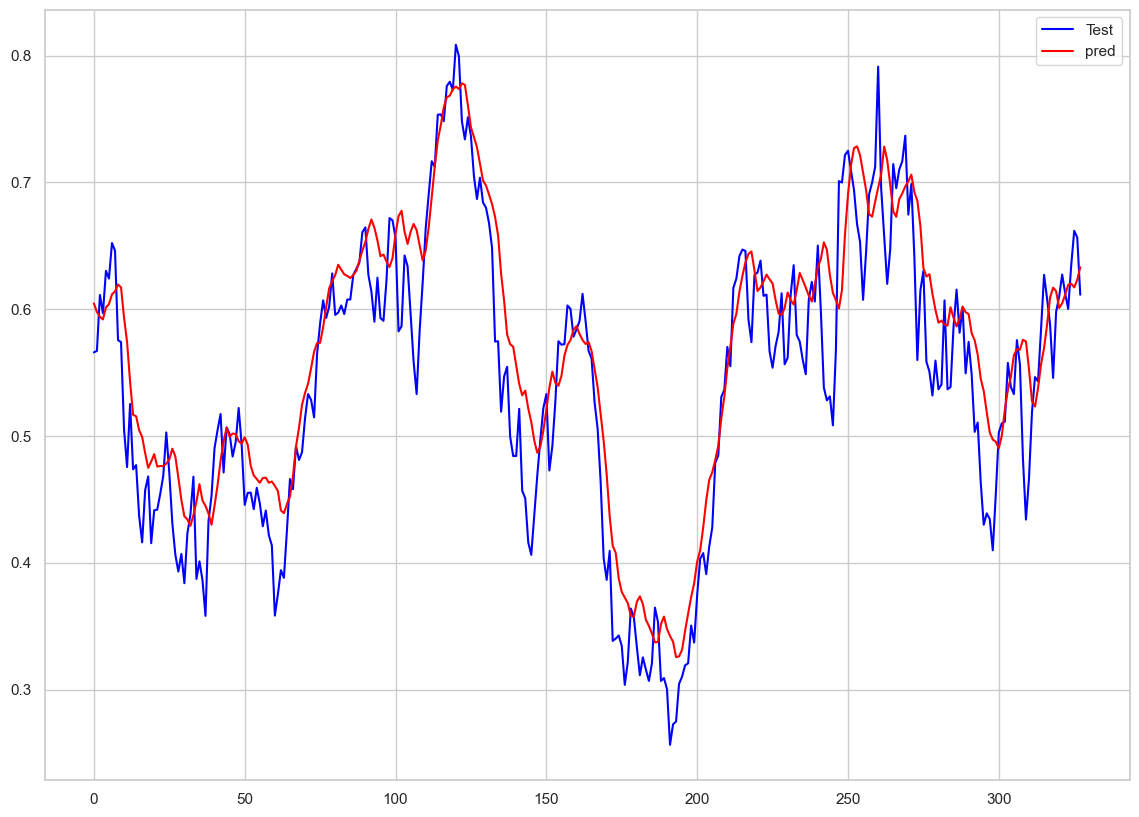

In [375]:
y_pred = model.predict(x_test)

plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_pred, color = 'red', label = 'pred')
plt.legend()
plt.show()

In [376]:
MAE(y_test,y_pred), MAPE(y_test, y_pred), RMSE(y_test, y_pred)

(0.03802909100211639, 7.763251566983335, 0.04784787914203964)

### 2. try a different method:
- Separete the last 90 values from the bova_11 values
- Format them with the same features as the prediction
- Do the predict on the next value
- invert the transformation to get the original values
- Recreate the dataframe with the same values and the prediction value
- Complete all the feature columns for the next input to predict
- make the next prediction
- put it into a for loop for n days
- predict for 1,5,30 and 90 days
- calculate the error metrics from all the predictions

In [410]:
def feature_calc(df):
    # Adding close change
    df["prev_close"] = df.shift(1)["close"]
    df["close_change"]= df.progress_apply(
        lambda row: 0 if np.isnan(row.prev_close) else row.close - row.prev_close,
        axis = 1
    )
    # Adding move Averages columns
    df['ma_3d'] = df['close'].rolling(3, center = True, min_periods=1).mean()
    df['ma_10d'] = df['close'].rolling(10, center = True,min_periods=1).mean()
    df['ma_30d'] = df['close'].rolling(30, center=True, min_periods=1).mean()
    df['ma_60d'] = df['close'].rolling(60, center = True, min_periods = 1).mean()
    # Adding standard deviation columns
    df['std_7'] = df['close'].rolling(7, center = True, min_periods = 1).std()
    df['std_30'] = df['close'].rolling(30, center = True, min_periods = 1).std()
    df['std_60'] = df['close'].rolling(60, center = True, min_periods = 1).std()
    # Adding the bollinger bands
    df['upper3'] = df['ma_3d'] + 2*df['close'].rolling(3, center = True, min_periods = 1).std()
    df['lower3'] = df['ma_3d'] - 2*df['close'].rolling(3, center = True, min_periods = 1).std()
    df['upper30'] = df['ma_30d'] + 2*df['std_30']
    df['lower30'] = df['ma_30d'] - 2*df['std_30']
    df['upper60'] = df['ma_60d'] + 2*df['std_60']
    df['lower60'] = df['ma_60d'] - 2*df['std_60']
    # Adding tecnical indicator RSI
    df['RSI'] = ta.rsi(df['close'], length = 15)
    df['target'] = df.close - df.open
    df['targetNextClose'] = df['close'].shift(-1)
    
    return df

In [489]:
def predict(df, days):
    # copy the dataframe to edit
    df_ = df.copy()
    
    for i in reversed(range(days+1)):
        if days > 0:
            # scale the features for the model prediction
            scaler = MinMaxScaler(feature_range = (-1, 1))
            df_scaled = scaler.fit_transform(df_)

            backcandles = pass_days #Defined by hyperparameters testing
            X = []
            for j in range(19): # range is the number of feature columns you will use
                X.append([])
                for k in range(backcandles, df_scaled.shape[0]):
                    X[j].append(df_scaled[k-backcandles:k, j])

            #move axis from 0 to position 2
            X = np.moveaxis(X, [0], [2])

            X, yi = np.array(X), np.array(df_scaled[backcandles:, -1]) # Chosing the last column as the pred. target
            y = np.reshape(yi, (len(yi), 1))

            splitlimit = int(len(X) * 0.9)
            x_test = X[splitlimit+1:] # take the last 10% of the original database

            if days > 1:
                x_test = x_test[-days:-(days-1)] 
            else:
                x_test = x_test[-days:]

            y_pred = model.predict(x_test) # make the prediction on the day to replace

            df_scaled[-days][3] = y_pred[0]

            predict_value = scaler.inverse_transform(df_scaled)[-days][3]

            df_.loc[(len(df_) - days) : (len(df_) - days), 'close'] = predict_value

            df_ = feature_calc(df_)
    
    return df_

In [450]:
bova11.reset_index(drop = True, inplace = True)

In [492]:
days= 10

In [493]:
df_teste = predict(bova11, days)

1/1 [==============================] - 0s 57ms/step


100%|██████████| 3384/3384 [00:00<00:00, 11199.58it/s]


1/1 [==============================] - 0s 66ms/step


100%|██████████| 3384/3384 [00:00<00:00, 13639.70it/s]


1/1 [==============================] - 0s 109ms/step


100%|██████████| 3384/3384 [00:00<00:00, 11324.11it/s]


1/1 [==============================] - 0s 45ms/step


100%|██████████| 3384/3384 [00:00<00:00, 16121.59it/s]


1/1 [==============================] - 0s 57ms/step


100%|██████████| 3384/3384 [00:00<00:00, 15820.79it/s]


1/1 [==============================] - 0s 48ms/step


100%|██████████| 3384/3384 [00:00<00:00, 16925.50it/s]


1/1 [==============================] - 0s 62ms/step


100%|██████████| 3384/3384 [00:00<00:00, 14981.54it/s]


1/1 [==============================] - 0s 101ms/step


100%|██████████| 3384/3384 [00:00<00:00, 13876.90it/s]


1/1 [==============================] - 0s 49ms/step


100%|██████████| 3384/3384 [00:00<00:00, 15020.30it/s]


1/1 [==============================] - 0s 47ms/step


100%|██████████| 3384/3384 [00:00<00:00, 16045.59it/s]


1/1 [==============================] - 0s 60ms/step


100%|██████████| 3384/3384 [00:00<00:00, 14629.35it/s]


In [494]:
df_teste.tail(days)

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,...,upper3,lower3,upper30,lower30,upper60,lower60,RSI,target,targetNextClose,prev_close
3374,106.940002,107.639999,106.690002,108.674689,0.414687,107.468231,107.477469,106.546188,105.389617,1.207911,...,110.954020,103.982441,111.805515,101.286860,111.454381,99.324853,58.546759,1.734686,105.470001,108.260002
3375,106.949997,106.949997,105.129997,105.470001,-3.204688,107.314898,107.772469,106.655195,105.346787,1.254025,...,110.627903,104.001892,111.910976,101.399415,111.466269,99.227305,50.031131,-1.479996,107.800003,108.674689
3376,106.239998,107.980003,106.220001,107.800003,2.330002,107.200002,108.027469,106.683682,105.278282,1.190652,...,110.242962,104.157042,112.050001,101.317363,111.418988,99.137575,55.116625,1.560005,108.330002,105.470001
3377,108.830002,109.599998,108.330002,108.330002,0.529999,108.413335,108.252469,106.753395,105.268776,1.185998,...,109.731260,107.095410,112.203192,101.303598,111.493052,99.044500,56.202951,-0.500000,109.110001,107.800003
3378,107.699997,109.540001,107.610001,109.110001,0.779999,108.630000,108.407470,106.841652,105.227908,1.291317,...,109.470000,107.789999,112.361214,101.322089,111.520306,98.935511,57.812988,1.410004,108.449997,108.330002
3379,109.110001,109.150002,108.010002,108.449997,-0.660004,108.486666,108.623469,106.843734,105.217563,1.005667,...,109.698331,107.275002,112.506652,101.180816,111.600583,98.834543,55.948353,-0.660004,107.900002,109.110001
3380,108.889999,109.330002,107.879997,107.900002,-0.549995,108.593333,108.617778,106.890773,105.266021,1.053531,...,110.143343,107.043323,112.692789,101.088758,111.718840,98.813202,54.382315,-0.989998,109.430000,108.449997
3381,108.709999,109.430000,107.970001,109.430000,1.529999,109.326668,109.011250,107.127483,105.307415,1.077788,...,112.082486,106.570850,112.707330,101.547636,111.841921,98.772909,57.895034,0.720001,110.650002,107.900002
3382,109.000000,110.680000,108.209999,110.650002,1.220001,110.166667,109.184286,107.518511,105.417022,1.199146,...,111.463175,108.870158,112.142744,102.894278,111.931639,98.902405,60.494028,1.650002,110.419998,109.430000
3383,110.699997,111.099998,109.860001,110.419998,-0.230003,110.535000,109.326667,107.868418,105.582087,1.250839,...,110.860274,110.209726,111.600506,104.136330,111.926463,99.237712,59.749056,-0.279999,NaN,110.650002


In [485]:
bova11.tail(days)

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,...,upper3,lower3,upper30,lower30,upper60,lower60,RSI,target,targetNextClose,prev_close


In [486]:
df_teste.loc[len(df_teste)-0:]

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,...,upper3,lower3,upper30,lower30,upper60,lower60,RSI,target,targetNextClose,prev_close


In [433]:
bova11.loc[len(bova11)-81:]

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,...,upper3,lower3,upper30,lower30,upper60,lower60,RSI,target,targetNextClose,prev_close
3303,103.639999,106.699997,103.510002,106.459999,2.659996,107.553335,108.427000,109.355334,109.326833,4.227940,...,116.359362,98.747307,115.749758,102.960910,114.956123,103.697544,50.440321,2.820000,112.400002,103.800003
3304,110.000000,112.400002,109.330002,112.400002,5.940002,110.403333,108.921000,109.480000,109.261833,4.291809,...,117.233571,103.573095,115.942819,103.017181,114.952058,103.571609,62.828068,2.400002,112.349998,106.459999
3305,114.019997,114.139999,111.760002,112.349998,-0.050003,112.690000,109.616000,109.514667,109.231167,3.874040,...,113.782337,111.597663,115.987747,103.041587,114.978900,103.483434,62.686745,-1.669998,113.320000,112.400002
3306,112.620003,113.480003,111.820000,113.320000,0.970001,113.046666,110.237000,109.574667,109.199833,2.425784,...,114.262618,111.830714,115.983581,103.165753,115.023033,103.376634,64.353291,0.699997,113.470001,112.349998
3307,113.589996,114.470001,113.010002,113.470001,0.150002,113.190000,110.781001,109.683000,109.149500,0.864716,...,113.915812,112.464188,116.003605,103.362395,115.028153,103.270847,64.615145,-0.119995,112.779999,113.320000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3379,109.110001,109.150002,108.010002,108.449997,-0.660004,108.486666,108.491000,106.777500,105.179715,1.005667,...,109.698331,107.275002,112.380924,101.174076,111.493662,98.865767,56.314016,-0.660004,107.900002,109.110001
3380,108.889999,109.330002,107.879997,107.900002,-0.549995,108.593333,108.617778,106.821053,105.227059,1.053531,...,110.143343,107.043323,112.564095,101.078010,111.610685,98.843434,54.687174,-0.989998,109.430000,108.449997
3381,108.709999,109.430000,107.970001,109.430000,1.529999,109.326668,109.011250,107.053889,105.267273,1.077788,...,112.082486,106.570850,112.582012,101.525766,111.732358,98.802188,58.279485,0.720001,110.650002,107.900002
3382,109.000000,110.680000,108.209999,110.650002,1.220001,110.166667,109.184286,107.440588,105.375625,1.199146,...,111.463175,108.870158,112.026505,102.854671,111.821238,98.930012,60.925992,1.650002,110.419998,109.430000


In [407]:
df_test = feature_calc(df_teste)

100%|██████████| 3384/3384 [00:00<00:00, 12223.69it/s]


In [408]:
df_teste.loc[len(df_teste)-102:len(df_teste)-98]

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,...,upper3,lower3,upper30,lower30,upper60,lower60,RSI,target,targetNextClose,prev_close
3282,106.209999,106.559998,105.589996,106.559998,1.509995,105.829999,105.508,103.775000,102.429644,2.199625,...,107.342475,104.317524,114.317114,93.232886,114.312699,90.546590,75.946497,0.349998,105.879997,105.050003
3283,107.309998,107.550003,105.760002,105.879997,-0.680000,107.026665,106.487,104.137667,102.665144,2.008995,...,109.902590,104.150739,114.159256,94.116078,114.589853,90.740435,72.323910,-1.430000,108.639999,106.559998
3284,106.769997,108.639999,106.309998,108.639999,2.760002,107.829999,107.233,104.512333,102.879144,1.978626,...,111.223585,104.436413,114.000717,95.023949,114.704734,91.053554,77.078542,1.870003,108.970001,105.879997
3285,107.550003,109.239998,107.099998,108.970001,0.330002,109.123334,107.712,104.901333,103.037477,1.670409,...,110.274394,107.972274,113.784852,96.017815,114.721798,91.353157,77.572136,1.419998,109.760002,108.639999
3286,109.000000,109.760002,108.750000,109.760002,0.790001,109.573334,107.905,105.291333,103.195477,1.512061,...,110.643347,108.503320,113.709158,96.873509,114.703745,91.687210,78.746065,0.760002,109.989998,108.970001


In [333]:
df_teste.loc[len(df_teste)-102:len(df_teste)-98]

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,...,std_60,upper3,lower3,upper30,lower30,upper60,lower60,RSI,target,targetNextClose
3282,106.830002,107.519997,105.699997,105.830002,-0.570000,106.273333,107.584999,107.788000,106.037667,1.093552,...,4.772493,107.064362,105.482305,110.602860,104.973140,115.582652,96.492681,52.762117,-1.000000,106.589996
3283,106.070000,106.589996,104.430000,106.589996,0.759995,106.503332,107.284999,107.907000,106.258833,1.084595,...,4.552362,107.772236,105.234427,110.807584,105.006416,115.363557,97.154110,55.271961,0.519997,107.089996
3284,107.360001,108.419998,106.709999,107.689831,0.500000,107.376663,107.164999,107.972333,106.501333,0.902078,...,4.344182,109.301796,105.451530,110.770479,105.174188,115.189697,97.812970,56.886658,-0.270004,108.449997
3285,108.269997,108.690002,107.779999,108.449997,1.360001,107.163330,107.273000,107.855333,106.776667,1.106446,...,4.149081,109.666555,104.660105,110.826161,104.884506,115.074829,98.478505,60.990697,0.180000,105.949997
3286,106.930000,107.080002,105.510002,105.949997,-2.500000,106.859998,107.131000,107.712333,107.036667,1.328807,...,3.996078,109.623545,104.096451,110.868366,104.556300,115.028822,99.044511,51.361284,-0.980003,106.180000


In [332]:
bova11.loc[len(bova11)-102:len(bova11)-98]

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,...,std_60,upper3,lower3,upper30,lower30,upper60,lower60,RSI,target,targetNextClose
3282,106.830002,107.519997,105.699997,105.830002,-0.570000,106.273333,107.584999,107.788000,106.037667,1.093552,...,4.772493,107.064362,105.482305,110.602860,104.973140,115.582652,96.492681,52.762117,-1.000000,106.589996
3283,106.070000,106.589996,104.430000,106.589996,0.759995,106.503332,107.284999,107.907000,106.258833,1.084595,...,4.552362,107.772236,105.234427,110.807584,105.006416,115.363557,97.154110,55.271961,0.519997,107.089996
3284,107.360001,108.419998,106.709999,107.689831,0.500000,107.376663,107.164999,107.972333,106.501333,0.902078,...,4.344182,109.301796,105.451530,110.770479,105.174188,115.189697,97.812970,56.886658,-0.270004,108.449997
3285,108.269997,108.690002,107.779999,108.449997,1.360001,107.163330,107.273000,107.855333,106.776667,1.106446,...,4.149081,109.666555,104.660105,110.826161,104.884506,115.074829,98.478505,60.990697,0.180000,105.949997
3286,106.930000,107.080002,105.510002,105.949997,-2.500000,106.859998,107.131000,107.712333,107.036667,1.328807,...,3.996078,109.623545,104.096451,110.868366,104.556300,115.028822,99.044511,51.361284,-0.980003,106.180000
